前置操作：
1. 统一附件格式

In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import os
import tqdm
import re
from sklearn import preprocessing
import librosa

plt.rcParams['font.sans-serif'] = ['SimHei']  # 黑体
plt.rcParams['axes.unicode_minus'] = False  # 解决无法显示符号的问题
palette = 'deep'
sns.set(font='SimHei', font_scale=1.2, palette=palette)  # 解决Seaborn中文显示问题

In [3]:

def loadFileHelper():
    df = None

    def loadFile(frame: pd.DataFrame) -> pd.DataFrame:
        nonlocal df
        if df is None:
            df = frame.copy()
            return df
        df = pd.concat([df, frame], axis=1)
        return df

    def final() -> pd.DataFrame:
        return df

    return loadFile, final

In [4]:

attachList = []
for dirI in range(1, 9):
    for root, _, files in os.walk(f'../3rd天府杯A提/附件{dirI}'):
        sorted_files = sorted(files, key=lambda x: int(os.path.splitext(x)[0]))
        attachList += [f'{os.path.join(root, i)}' for i in sorted_files]

print(len(attachList))

170


In [5]:
helper, getFinalDf = loadFileHelper()

tqdmList = tqdm.tqdm(attachList)
for i in tqdmList:
    res = re.search(r'附件(\d+)\\(\d+)', i)
    header = '-'.join(res.groups())
    tqdmList.set_description(i, header)
    df = pd.read_table(i, sep=r'\n', header=None, engine='python')
    df.columns = [header]
    helper(df)

df = getFinalDf()
df

../3rd天府杯A提/附件8\30.txt: 100%|██████████| 170/170 [00:03<00:00, 44.94it/s]


,1-1,1-2,1-3,1-4,1-5,1-6,1-7,1-8,1-9,1-10,...,8-21,8-22,8-23,8-24,8-25,8-26,8-27,8-28,8-29,8-30
0,0.031847,0.016663,0.020103,0.005837,-0.011276,-0.025771,0.021692,0.009281,0.010529,0.001247,...,-9.679108,-2.319808,-18.703373,6.533483,20.799034,-53.410206,9.416552,11.053165,-5.428255,-11.606074
1,-0.011189,-0.002048,0.006537,0.023145,0.012113,-0.017351,0.010933,-0.003817,0.004915,-0.007641,...,-9.327146,-5.516180,-24.892555,-0.396517,5.738626,-61.589596,8.462877,15.089084,-4.420704,-10.087299
2,-0.019609,-0.007661,-0.002818,0.003030,0.021468,-0.009866,0.007658,-0.004752,0.003980,-0.002028,...,-7.958519,-7.522062,-28.146841,-7.194655,-9.456475,-69.321838,7.138796,17.843573,-2.655398,-9.089544
3,0.019685,0.007308,-0.002351,-0.019423,0.004160,-0.003318,0.005787,-0.018318,-0.022216,-0.028223,...,-5.693323,-8.335984,-28.462965,-13.267302,-23.552597,-75.982040,5.501653,19.054186,-0.385398,-8.460361
4,-0.020076,0.001226,-0.020594,0.016596,0.013048,-0.015948,-0.000294,-0.023931,0.003045,-0.024481,...,-2.737343,-8.099121,-26.189087,-18.153183,-35.564842,-81.187347,3.600021,18.593573,2.107255,-7.919340
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7995,-2.936200,1.122488,1.303684,-0.291669,-0.145528,0.035976,0.138636,-0.077726,0.077889,-0.176508,...,14.900795,34.438034,-22.248474,2.227601,55.010464,-41.308983,-25.541817,-9.548468,36.734196,58.555965
7996,-3.392283,2.000974,0.883152,-0.199985,0.457904,0.205311,0.186349,-0.010833,0.116246,-0.133005,...,7.446579,38.533329,-21.719902,6.016424,54.616383,-17.208982,-33.014061,-8.434589,43.017868,52.443722
7997,-2.868840,1.194994,0.248846,0.020338,0.813415,0.481300,0.176526,-0.000075,0.141039,-0.115230,...,1.258834,42.375584,-20.843985,9.369366,52.959850,7.429181,-39.193447,-7.400916,48.391541,46.517189
7998,-2.935732,-0.888954,-0.528132,0.284164,0.943457,0.712382,0.149862,-0.014108,0.181735,-0.082953,...,-3.315088,45.779606,-19.569902,12.115640,49.998829,30.841425,-43.725285,-6.257651,52.505825,40.839844


In [6]:
天然地震df = df.iloc[:, :-30]
人工爆破df = df.iloc[:, -30:]

In [7]:
from scipy.stats import *


def 计算样本熵(mfccs: np.ndarray):
    # 计算样本熵
    sample_entropy = np.zeros(mfccs.shape[0])

    for i in range(mfccs.shape[0]):
        data = mfccs[i]
        data_nonnegative = data - np.min(data) + 1e-10
        sample_entropy[i] = entropy(data_nonnegative)

    return sample_entropy


def 计算mfccs样本熵(y: np.ndarray):
    mfccs, mfcc_delta, mfcc_delta2, = 计算mfcc(y)
    '''
    mfccs, mfcc_delta, mfcc_delta2 这三个都一行一个特征
    '''
    sampleMfccs = 计算样本熵(mfccs)
    sampleMfccDelta = 计算样本熵(mfcc_delta)
    sampleMfccDelta2 = 计算样本熵(mfcc_delta2)
    # print(sampleMfccs)
    sampleMatrix = np.asarray([sampleMfccs, sampleMfccDelta, sampleMfccDelta2]).T
    return sampleMatrix, mfccs, mfcc_delta, mfcc_delta2, sampleMfccs, sampleMfccDelta, sampleMfccDelta2


def 计算mfcc(y: np.ndarray):
    sr = 22050
    '''
    y.shape=(N,1)
    '''
    mfccs = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=12)
    mfcc_delta = librosa.feature.delta(mfccs)
    mfcc_delta2 = librosa.feature.delta(mfcc_delta)
    return mfccs, mfcc_delta, mfcc_delta2

In [8]:
sample, mfccs, mfcc_delta, mfcc_delta2, sampleMfccs, sampleMfccDelta, sampleMfccDelta2 = \
    计算mfccs样本熵(df['1-1'].values)
sample

array([[2.31369732, 2.31266738, 2.23696574],
       [2.2875233 , 2.3033458 , 2.35557882],
       [2.38617241, 2.36810012, 2.2835953 ],
       [2.49913533, 2.46599023, 2.23829804],
       [2.31039239, 2.34790356, 2.29198842],
       [2.56874132, 2.27770206, 2.30201959],
       [2.56444611, 2.60456116, 2.50681607],
       [2.5075381 , 2.32243481, 2.50037187],
       [2.31574103, 2.35316145, 2.30774251],
       [2.4320335 , 2.29520686, 2.49843144],
       [2.53432791, 2.46338724, 2.27034188],
       [2.65030713, 2.31724605, 2.1036783 ]])

In [9]:
sampleMfccs

array([2.31369732, 2.2875233 , 2.38617241, 2.49913533, 2.31039239,
       2.56874132, 2.56444611, 2.5075381 , 2.31574103, 2.4320335 ,
       2.53432791, 2.65030713])

In [10]:
'''
12行，也就是12个特征
16列， ceil(采样率*时间 / 帧移)
'''
mfccs

array([[-2.90458396e+02, -2.72692046e+02, -2.74538773e+02,
        -2.75722261e+02, -2.73177344e+02, -2.75337457e+02,
        -2.15430425e+02,  1.35453802e+01,  1.13897439e+02,
         1.46509874e+02,  1.74658948e+02,  2.20276159e+02,
         2.55182901e+02,  2.63161241e+02,  2.26205693e+02,
         2.08280864e+02],
       [ 5.01720701e-02, -5.35100012e+00, -9.56662334e+00,
        -1.18633629e+01, -1.02617420e+01, -1.15677667e+01,
         5.03964909e+00, -2.22049119e+00, -6.23003668e+00,
        -5.72556944e+00,  1.52122586e+01,  3.36000158e+01,
         3.65665996e+01,  3.83698671e+01,  2.60578734e+01,
         3.46774263e+01],
       [ 9.66196665e+00,  6.47219908e+00,  4.40412113e+00,
         4.72873957e+00,  6.65532176e+00,  3.09144394e+00,
        -2.08529613e+01, -7.33112278e+01, -8.48984469e+01,
        -8.96925507e+01, -7.94765966e+01, -8.44006884e+01,
        -1.03477957e+02, -1.04814510e+02, -9.89845166e+01,
        -7.26875046e+01],
       [-6.06669417e+00, -1.15396307e

In [11]:
def 计算整个df的各阶样本熵():
    sampleNdarr = None
    mfccsNdarr = None
    mfcc1Ndarr = None
    mfcc2Ndarr = None
    for item in df.columns:
        sample, mfccs, mfcc_delta, mfcc_delta2, sampleMfccs, sampleMfccDelta, sampleMfccDelta2 = \
            计算mfccs样本熵(df[item].values)
        if sampleNdarr is None:
            sampleNdarr = sample
            mfccsNdarr = mfccs
            mfcc1Ndarr = mfcc_delta
            mfcc2Ndarr = mfcc_delta2
            continue
        sampleNdarr = np.hstack((sampleNdarr, sample))
        mfccsNdarr = np.hstack((mfccsNdarr, mfccs))
        mfcc1Ndarr = np.hstack((mfcc1Ndarr, mfcc_delta))
        mfcc2Ndarr = np.hstack((mfcc2Ndarr, mfcc_delta2))
    return sampleNdarr, mfccsNdarr, mfcc1Ndarr, mfcc2Ndarr


sampleNdarr, mfccsNdarr, mfcc1Ndarr, mfcc2Ndarr = 计算整个df的各阶样本熵()
mfcc静态系数样本熵 = sampleNdarr[:, 0::3]
mfcc一阶差分样本熵 = sampleNdarr[:, 1::3]
mfcc二阶差分样本熵 = sampleNdarr[:, 2::3]

In [12]:
mfccsNdarr

array([[-2.90458396e+02, -2.72692046e+02, -2.74538773e+02, ...,
         4.74813882e+02,  4.73623590e+02,  4.67543456e+02],
       [ 5.01720701e-02, -5.35100012e+00, -9.56662334e+00, ...,
         1.28179438e+02,  1.26796040e+02,  1.21205198e+02],
       [ 9.66196665e+00,  6.47219908e+00,  4.40412113e+00, ...,
         5.07888810e+01,  5.04178664e+01,  5.13821666e+01],
       ...,
       [ 2.24421510e+00,  2.54107005e+00,  1.08409218e+00, ...,
        -7.62968310e-01,  1.29633567e+00,  5.06417885e+00],
       [-2.25372227e+00, -2.71906958e+00, -1.45752597e+00, ...,
         6.91848625e+00,  5.12897151e+00,  4.97735114e+00],
       [ 6.09022623e+00,  6.75314864e+00,  6.33687888e+00, ...,
         7.11359573e+00,  3.29824475e+00,  2.85567768e+00]])

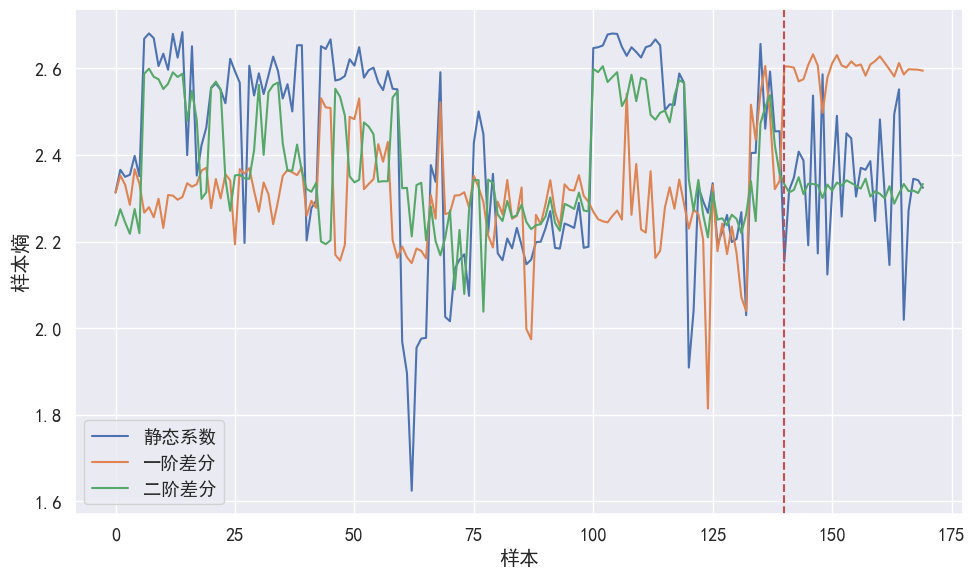

In [13]:
显示mfcc维度 = 0
plt.figure(figsize=(10, 6))
sns.lineplot(mfcc静态系数样本熵[显示mfcc维度], label='静态系数')
# sns.scatterplot(mfcc静态系数ndarr[0])
#
sns.lineplot(mfcc一阶差分样本熵[显示mfcc维度], label='一阶差分')
# sns.scatterplot(mfcc一阶差分ndarr[0])
#
sns.lineplot(mfcc二阶差分样本熵[显示mfcc维度], label='二阶差分')
# sns.scatterplot(mfcc二阶差分ndarr[0])

plt.axvline(x=mfcc静态系数样本熵.shape[1] - 30, color='r', linestyle='--')
plt.ylabel('样本熵')
plt.xlabel('样本')
plt.tight_layout()
plt.show()

In [14]:
mfccDf = pd.DataFrame(
    np.asarray(
        (mfcc静态系数样本熵[显示mfcc维度], mfcc一阶差分样本熵[显示mfcc维度], mfcc二阶差分样本熵[显示mfcc维度])).T,
    columns=['静态系数', '一阶差分', '二阶差分'])
mfccDf

,静态系数,一阶差分,二阶差分
0,2.313697,2.312667,2.236966
1,2.365711,2.352702,2.274795
2,2.349605,2.331472,2.244524
3,2.354266,2.284682,2.217881
4,2.398041,2.367101,2.275127
...,...,...,...
165,2.019267,2.585894,2.332974
166,2.271963,2.598065,2.316562
167,2.345049,2.597429,2.317779
168,2.341758,2.597124,2.312072


In [15]:
mfccMeltDf = pd.melt(mfccDf, var_name='类别', value_name='值')
mfccMeltDf.to_excel('mfccMeltDf.xlsx', index=False)
mfccMeltDf

,类别,值
0,静态系数,2.313697
1,静态系数,2.365711
2,静态系数,2.349605
3,静态系数,2.354266
4,静态系数,2.398041
...,...,...
505,二阶差分,2.332974
506,二阶差分,2.316562
507,二阶差分,2.317779
508,二阶差分,2.312072


D:\Users\win\AppData\Local\Temp\ipykernel_70320\2582910030.py:1: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(mfcc静态系数样本熵[0], fit=norm, kde=True, bins=6)


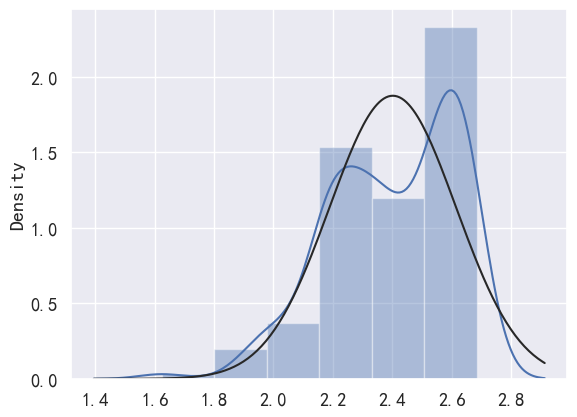

In [16]:
sns.distplot(mfcc静态系数样本熵[0], fit=norm, kde=True, bins=6)
plt.show()

# 导出用于SVM数据

In [17]:
提取n_mfcc = 0
svmDf = pd.DataFrame(
    np.asarray([mfcc静态系数样本熵[提取n_mfcc], mfcc一阶差分样本熵[提取n_mfcc], mfcc二阶差分样本熵[提取n_mfcc]]).T,
    columns=['静态系数', '一阶差分', '二阶差分'])
svmDf

,静态系数,一阶差分,二阶差分
0,2.313697,2.312667,2.236966
1,2.365711,2.352702,2.274795
2,2.349605,2.331472,2.244524
3,2.354266,2.284682,2.217881
4,2.398041,2.367101,2.275127
...,...,...,...
165,2.019267,2.585894,2.332974
166,2.271963,2.598065,2.316562
167,2.345049,2.597429,2.317779
168,2.341758,2.597124,2.312072


In [18]:
svmDf['人工地震'] = [0] * (svmDf.shape[0] - 30) + [1] * 30
svmDf

,静态系数,一阶差分,二阶差分,人工地震
0,2.313697,2.312667,2.236966,0
1,2.365711,2.352702,2.274795,0
2,2.349605,2.331472,2.244524,0
3,2.354266,2.284682,2.217881,0
4,2.398041,2.367101,2.275127,0
...,...,...,...,...
165,2.019267,2.585894,2.332974,1
166,2.271963,2.598065,2.316562,1
167,2.345049,2.597429,2.317779,1
168,2.341758,2.597124,2.312072,1


In [19]:
svmDf.to_excel('导入svm数据.xlsx', index=False)